In [6]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# convert an array of values into a dataset matrix
def create_dataset(trainX, trainY, look_back=1):
    dataX, dataY = [], []
    for i in range(len(trainX)-look_back-1):
        a = trainX[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(trainY[i + look_back])
    return np.array(dataX), np.array(dataY)

In [7]:
from IPython.display import clear_output
# Live plot for loss during training
# Taken from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        # Reset the plot to only have the last 100 epochs
        if len(self.x) % 100 == 0:
            self.on_train_begin()
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

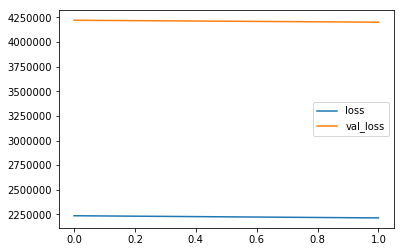

1864/1864 [==============================] - 0s - loss: 2214143.9276 - val_loss: 4201564.5567
Epoch 3/2000
1000/1864 [===============>..............] - ETA: 0s - loss: 2199914.5187

KeyboardInterrupt: 

In [20]:

# Extract data from files
latent_val = pd.read_csv('sae_output_5000.csv')
latent_val = np.array(latent_val)
y_lazy = pd.read_csv('data/sp500_index_data.csv')['Close Price']
y_train = y_lazy.shift(-1)
y_train = np.array(y_train)
#this means we have an na for the last value training is latent_val, target y_train

# Preparing the datasets with look_back parameters
look_back =4
trainX_fixed = latent_val[:-1]
trainX = trainX_fixed[:round(0.9*len(trainX_fixed))]
testX = trainX_fixed[round(0.9*len(trainX_fixed)):]

trainY_fixed = np.array(y_train[:-1])
trainY = trainY_fixed[:round(0.9*len(trainY_fixed))]
testY = trainY_fixed[round(0.9*len(trainY_fixed)):]

# Delete unnecessary arrays
del trainX_fixed
del trainY_fixed

trainX, trainY = create_dataset(trainX, trainY, look_back)
testX, testY = create_dataset(testX, testY, look_back) 



# create and fit the LSTM network
LEARNING_RATE = 0.005
BATCH_SIZE = 50
EPOCHS = 2000
opti_adam = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 10)))
#model.add(LSTM(20, input_shape=(look_back, 10)))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opti_adam)
model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE,
          verbose=1, callbacks=[plot_losses], validation_data=(testX, testY))

[[ 17.40629578]
 [ 17.40629578]
 [ 17.40658569]
 ..., 
 [ 17.42842102]
 [ 17.42842484]
 [ 17.42787552]]


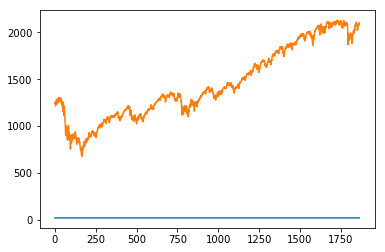

In [21]:
bugger = model.predict(trainX)
print(bugger)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(bugger)
plt.plot(trainY)
plt.show()

1863
1863


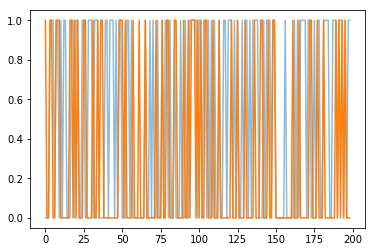

[ 17.40629578  17.40629578  17.40658569 ...,  17.42842102  17.42842484
  17.42787552]


In [22]:
diff_bugger = np.diff(bugger[:,0])
diff_bugger = [1 if x > 0 else 0 for x in diff_bugger]
diff_trainY = np.diff(trainY)
diff_trainY = [1 if x > 0 else 0 for x in diff_trainY]
print(len(diff_trainY))
print(len(diff_bugger))
plt.plot(diff_trainY[1:200], alpha = 0.5)
plt.plot(diff_bugger[1:200])
plt.show()
print(bugger[:,0])

In [25]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(diff_bugger, diff_trainY, labels=[0,1])
print(conf_mat)
print("Accuracy price move prediction: {}".format(np.trace(conf_mat) / np.sum(conf_mat)))

[[599 679]
 [249 336]]
Accuracy price move prediction: 0.5018786902844874


In [ ]:
(586+747) / (586+747 + 268 + 262)

In [125]:
def compute_mape(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sum(np.abs((y-y_pred) / y)) / len(y)

compute_mape(bugger, trainY)

697.04579441335841